# Creating the IOOS Asset Inventory

This notebook walks through the process for creating the asset inventory from the spreadsheets collected from the Regional Associations.

First we need to import some libraries and enable KML support.

In [1]:
import fiona
import geopandas
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

Now we identify the directory where the excel spreadsheets are found. This should be edited to correspond with the appropriate year and file type to be processed.

In [2]:
year = '2023'
dir = year+'/data/processed/'
all_files = os.listdir(dir)

regex = re.compile(r'~.*')

files = [i for i in all_files if not regex.match(i)]

print('Found %i Excel workbooks' % len(files))

Found 10 Excel workbooks


Now start building the pandas DataFrame to capture the information in the spreadsheets. We do some minor cleaning here, including:
 * dropping empty rows
 * removing special characters
 * adding RA column if spreadsheet doesn't have it

In [3]:
df_raw = pd.DataFrame(
    columns=['RA', 'Station ID', 'WMO ID or NWS/CMAN ID', 'Station Long Name',
       'Station Description', 'Latitude (dec deg)', 'Longitude (dec deg)',
       'Platform Type', 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)',
       'Currently Operational? (Y, N, O, U)', 'Platform Funder/Sponsor',
       'RA Funding Involvement (Yf, Yp, N)', 'Platform Operator/Owner',
       'Operator Sector', 'Platform Maintainer', 'Data Manager',
       'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].',
       'Additional notes', 'file']
)
for file in files:
    fname = dir + file

    print('Reading %s' % file)
    df = pd.read_excel(fname, header=0)

    # Drop empty rows
    df.dropna(axis='index', how='all', inplace=True)
    # Removing special chars
    df.replace('\xa0', '', regex=True, inplace=True)
    df.replace('\n','', regex=True, inplace=True) # remove carriage returns

    # create RA column if missing
    if 'RA' not in df.columns:
        df['RA'] = file.split(".")[0]

    # add the file name for use later
    df['file'] = file

    # concatenate data frames into one mongo DF.
    df_raw = pd.concat([df_raw, df], ignore_index=True)

    # print some information out
    print('Ingested %s with %i columns' % (file, len(df.columns)))

print('Initial row count: %i' % df_raw.shape[0])

Reading AOOS.xlsx
Ingested AOOS.xlsx with 19 columns
Reading CARICOOS.xlsx
Ingested CARICOOS.xlsx with 19 columns
Reading CENCOOS.xlsx
Ingested CENCOOS.xlsx with 19 columns
Reading GCOOS.xlsx
Ingested GCOOS.xlsx with 19 columns
Reading GLOS.xlsx
Ingested GLOS.xlsx with 17 columns
Reading NANOOS.xlsx
Ingested NANOOS.xlsx with 19 columns
Reading NERACOOS.xlsx
Ingested NERACOOS.xlsx with 19 columns
Reading PACIOOS.xlsx
Ingested PACIOOS.xlsx with 19 columns
Reading SCCOOS.xlsx
Ingested SCCOOS.xlsx with 19 columns
Reading SECOORA.xlsx
Ingested SECOORA.xlsx with 19 columns
Initial row count: 902


Let's clean up the headers for the source data.

In [4]:
columns = {
       'Station ID': 'Station_ID', 
       'WMO ID or NWS/CMAN ID': 'WMO_CMAN_ID', 
       'Station Long Name': 'Station_Long_Name',
       'Station Description': 'Station_Description', 
       'Latitude (dec deg)': 'Latitude', 
       'Longitude (dec deg)': 'Longitude',
       'Platform Type': 'Platform_Type', 
       'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station_Deployment',
       'Currently Operational? (Y, N, O, U)': 'Currently_Operational', 
       'Platform Funder/Sponsor': 'Platform_Funder',
       'RA Funding Involvement (Yf, Yp, N)':'RA_Funded', 
       'Platform Operator/Owner': 'Platform_Operator',
       'Operator Sector': 'Operator_Sector', 
       'Platform Maintainer': 'Platform_Maintainer', 
       'Data Manager':'Data_Manager',
       'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].': 'Variable_Names',
       'Additional notes': 'Additional_notes',
}

df_raw.rename(columns=columns, inplace=True)

df_raw

,RA,Station_ID,WMO_CMAN_ID,Station_Long_Name,Station_Description,Latitude,Longitude,Platform_Type,Station_Deployment,Currently_Operational,Platform_Funder,RA_Funded,Platform_Operator,Operator_Sector,Platform_Maintainer,Data_Manager,Variable_Names,Additional_notes,file,Dataset (ERDDAP) ID
0,AOOS,CSESM,NOT REAL TIME,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring with...,71.5997,-161.5054,moored_buoy,2014-09-20 00:00:00,Y - but never real time,"AOOS, NPRB, UAF, others",Yp,UAF_CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature (35m, 48m, near-bottom),...",two to three moorings at the CEO which are rot...,AOOS.xlsx,NaN
1,AOOS,CEO1,Not real time,CEO1 (part of the CSEM),NaN,71.5997,-161.5054,moored_buoy,2014-09-21 00:00:00,Y - but never real time,same as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",Data visualizaed on the AOOS Portal includes 2...,AOOS.xlsx,NaN
2,AOOS,CEO2,Not real time,CEO2 (part of the CSEM),NaN,71.5998,-161.5261,moored_buoy,2015-08-20 00:00:00,Y- but never real time,sames as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",This is the list of all sensors reporting to t...,AOOS.xlsx,NaN
3,AOOS,urn:gulf-of-alaska-ecosystem-obse,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,"Y - but not real time at moment, so data not u...","M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...,AOOS.xlsx,NaN
4,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.6966,Fixed moored_buoy,2019-07-11 00:00:00,Y - but not real time at moment,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper...",AOOS.xlsx,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,SECOORA,Turner Creek Boat Ramp,NaN,Turner Creek Boat Ramp,Water Level Sensor,32.020471,-80.991889,water_level,2022-02-12 00:00:00,y,NaN,NaN,Geogia Tech,Academic,Geogia Tech,SECOORA,water_surface_height_above_reference_datum,Water level sensor mounted to structure on lan...,SECOORA.xlsx,NaN
898,SECOORA,Walthour Road,NaN,Walthour Road,Water Level Sensor,32.018171,-80.962163,water_level,2022-02-12 00:00:00,y,NaN,NaN,Geogia Tech,Academic,Geogia Tech,SECOORA,water_surface_height_above_reference_datum,Water level sensor mounted to structure on lan...,SECOORA.xlsx,NaN
899,SECOORA,Lazaretto Creek Fishing Pier,NaN,Lazaretto Creek Fishing Pier,Water Level Sensor,32.014112,-80.884092,water_level,2022-02-12 00:00:00,y,NaN,NaN,Geogia Tech,Academic,Geogia Tech,SECOORA,water_surface_height_above_reference_datum,Water level sensor mounted to structure on lan...,SECOORA.xlsx,NaN
900,SECOORA,Catalina Drive,NaN,Catalina Drive,Water Level Sensor,32.006419,-80.866956,water_level,2022-02-12 00:00:00,y,NaN,NaN,Geogia Tech,Academic,Geogia Tech,SECOORA,water_surface_height_above_reference_datum,Water level sensor mounted to structure on lan...,SECOORA.xlsx,NaN


Now we need to do a little cleaning to remove platform types that shouldn't be part of the inventory. So, we create a copy of the dataFrame for processing and remove the rows that have platforms of `surface_current_radar` and `glider`.

In [5]:
df_all = df_raw.copy()

df_all['RA'] = df_all['RA'].astype(str).str.strip()

print('Removing platform type = \'surface_current_radar\' | \'glider\'.')
df_all.drop(
    df_all.loc[
        (df_all['Platform_Type'] == 'surface_current_radar') |
        (df_all['Platform_Type'] == 'glider')
    ].index,
    inplace=True)
print('row count:', df_all.shape[0])

Removing platform type = 'surface_current_radar' | 'glider'.
row count: 902


Convert lat/lon to floating points.

In [6]:
#df_all.drop(
#    df_all.loc[df_all['Latitude (dec deg)'] == '(Required) '].index,
#    inplace=True)

In [7]:
#df_all.loc[df_all['Latitude (dec deg)'] == '35 15.555', ['file']]

In [8]:
df_all[['Latitude', 'Longitude']] = df_all[['Latitude', 'Longitude']].astype(float)

Find all bad coordinates and tell me which file they belong to and what the coordinates are.

In [9]:
df_all.loc[(df_all['Longitude']<-180) | (df_all['Longitude'] > 180) | (df_all['Latitude'] > 90) | (df_all['Latitude'] < -90), ['Latitude','Longitude','file']]

,Latitude,Longitude,file


In [10]:
df_all['RA_Funded'].unique()

array(['Yp', 'N', 'Yf', nan, 'Y', 'YP',
       'N (install, OnM);  Y  (AOOS paid for conversion of GNSS-R data for Water Level)',
       'N (install, OnM); Y (AOOS is paying JOA Surveys for conversion and providing real time GNSS-R converted water level data)',
       'Yf (AOOS funded the installation); Yp UNAVCO is payin for data filtration costs',
       'yp', 'n', 'N '], dtype=object)

In [11]:
df_all['Currently_Operational'].unique()

array(['Y - but never real time', 'Y- but never real time',
       'Y - but not real time at moment, so data not updated as of 12/2019',
       'Y - but not real time at moment', 'Y - but no real time', 'Y',
       'N', 'y', 'O', 'Operational', 'Offline', 'No', 'o', 'n', 'N Y',
       'U', 'U - no longer funded '], dtype=object)

In [12]:
df_all.loc[df_all['RA_Funded'].isna()]

,RA,Station_ID,WMO_CMAN_ID,Station_Long_Name,Station_Description,Latitude,Longitude,Platform_Type,Station_Deployment,Currently_Operational,Platform_Funder,RA_Funded,Platform_Operator,Operator_Sector,Platform_Maintainer,Data_Manager,Variable_Names,Additional_notes,file,Dataset (ERDDAP) ID
39,AOOS,kotzebue-sound-ak,KOZA2,"Kotzebue Sound, AK","Weather, AIS",66.900900,-162.589500,Fixed,2023-02-28 00:00:00,Y,MXAK,NaN,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",new in 2023,AOOS.xlsx,NaN
197,CeNCOOS,Morro Back Bay,N/A recent station,Morro Back Bay BS1,Morro Back Bay BS1,35.333820,-120.847250,fixed pier,2018-09-20 00:00:00,y,Cal Poly/CeNCOOS,NaN,Cal Poly,Academic,Cal Poly,Cal Poly,"sea_water_temperature(1m), sea_water_pressure(...",NaN,CENCOOS.xlsx,NaN
787,SECOORA,MSNB_N,MBNN7,Masonboro Island North,"Custom instrumment tower, 10' in height.",34.171200,-77.823400,fixed,2021-01-14 00:00:00,Y,UNCW/NSF,NaN,UNCW,Academic,UNCW,UNCW,"air_pressure, air_temperature, relative_humidi...",NaN,SECOORA.xlsx,NaN
788,SECOORA,MSNB_S,MBIN7,Masonboro Island South,"Custom instrumment tower, 10' in height.",34.090600,-77.867900,fixed,2020-12-17 00:00:00,Y,UNCW/NSF,NaN,UNCW,Academic,UNCW,UNCW,"air_pressure, air_temperature, relative_humidi...",NaN,SECOORA.xlsx,NaN
818,SECOORA,Eastern Lake Park Boat Ramp,NaN,"Eastern Lake Boat Ramp (florida_panhandle_1), ...",Water Level Sensor/ Weather Station,30.455400,-86.587634,fixed,2023-05-01 00:00:00,Y,SECOORA,NaN,FAU,Academic,FAU/ Florida Seagrant,FAU,water_surface_height_above_reference_datum,Water level sensor mounted to structure on lan...,SECOORA.xlsx,NaN
819,SECOORA,Poquito Bayou Boat Ramp,NaN,"Poquito Bayou Boat ramp (florida_panhandle_2),...",Water Level Sensor/ Weather Station,30.309557,-86.089639,fixed,2023-05-01 00:00:00,Y,FAU,NaN,FAU,Academic,FAU/ Florida Seagrant,FAU,water_surface_height_above_reference_datum,Water level sensor mounted to structure on lan...,SECOORA.xlsx,NaN
820,SECOORA,Ribault River Reserve,NaN,Ribault River Reserve,Water Level Sensor/ Weather Station,30.398898,-81.698653,fixed,2023-10-01 00:00:00,Y,SECOORA,NaN,FAU,Academic,FAU,FAU,water_surface_height_above_reference_datum,Water level sensor mounted to structure on lan...,SECOORA.xlsx,NaN
821,SECOORA,Whitepoint Swash WL,NaN,"White Point Swash,(whitepoint_wl_1), North Myr...",Water Level Sensor,33.792624,-78.736681,fixed,jul 21/ replacedSep-23,Y,CCU,NaN,CCU,Academic,CCU,FAU,water_surface_height_above_reference_datum,Water level sensor mounted to structure on lan...,SECOORA.xlsx,NaN
822,SECOORA,Atlantic Avenue Causeway Bridge Fishing Pier (WL),NaN,"Atlantic Avenue Causeway(murrells_inlet_2), Ga...",Water Level Sensor,33.579828,-79.003625,fixed,2023-07-22 00:00:00,Y,CCU,NaN,CCU,Academic,CCU,FAU,water_surface_height_above_reference_datum,Water level sensor mounted to structure on lan...,SECOORA.xlsx,NaN
823,SECOORA,Barefoot Resort Swing Bridge,NaN,"Barefoot Resort Swing Bridge, North Myrtle Bea...",Water Level Sensor,33.802873,-78.741159,fixed,2022-03-30 00:00:00,Y,CCU,NaN,CCU,Academic,CCU,FAU,water_surface_height_above_reference_datum,Water level sensor mounted to structure on lan...,SECOORA.xlsx,NaN


Saving dates as strings

In [13]:
df_all['Station_Deployment'] = \
    df_all['Station_Deployment'].astype(str)

Make a simple plot of station locations

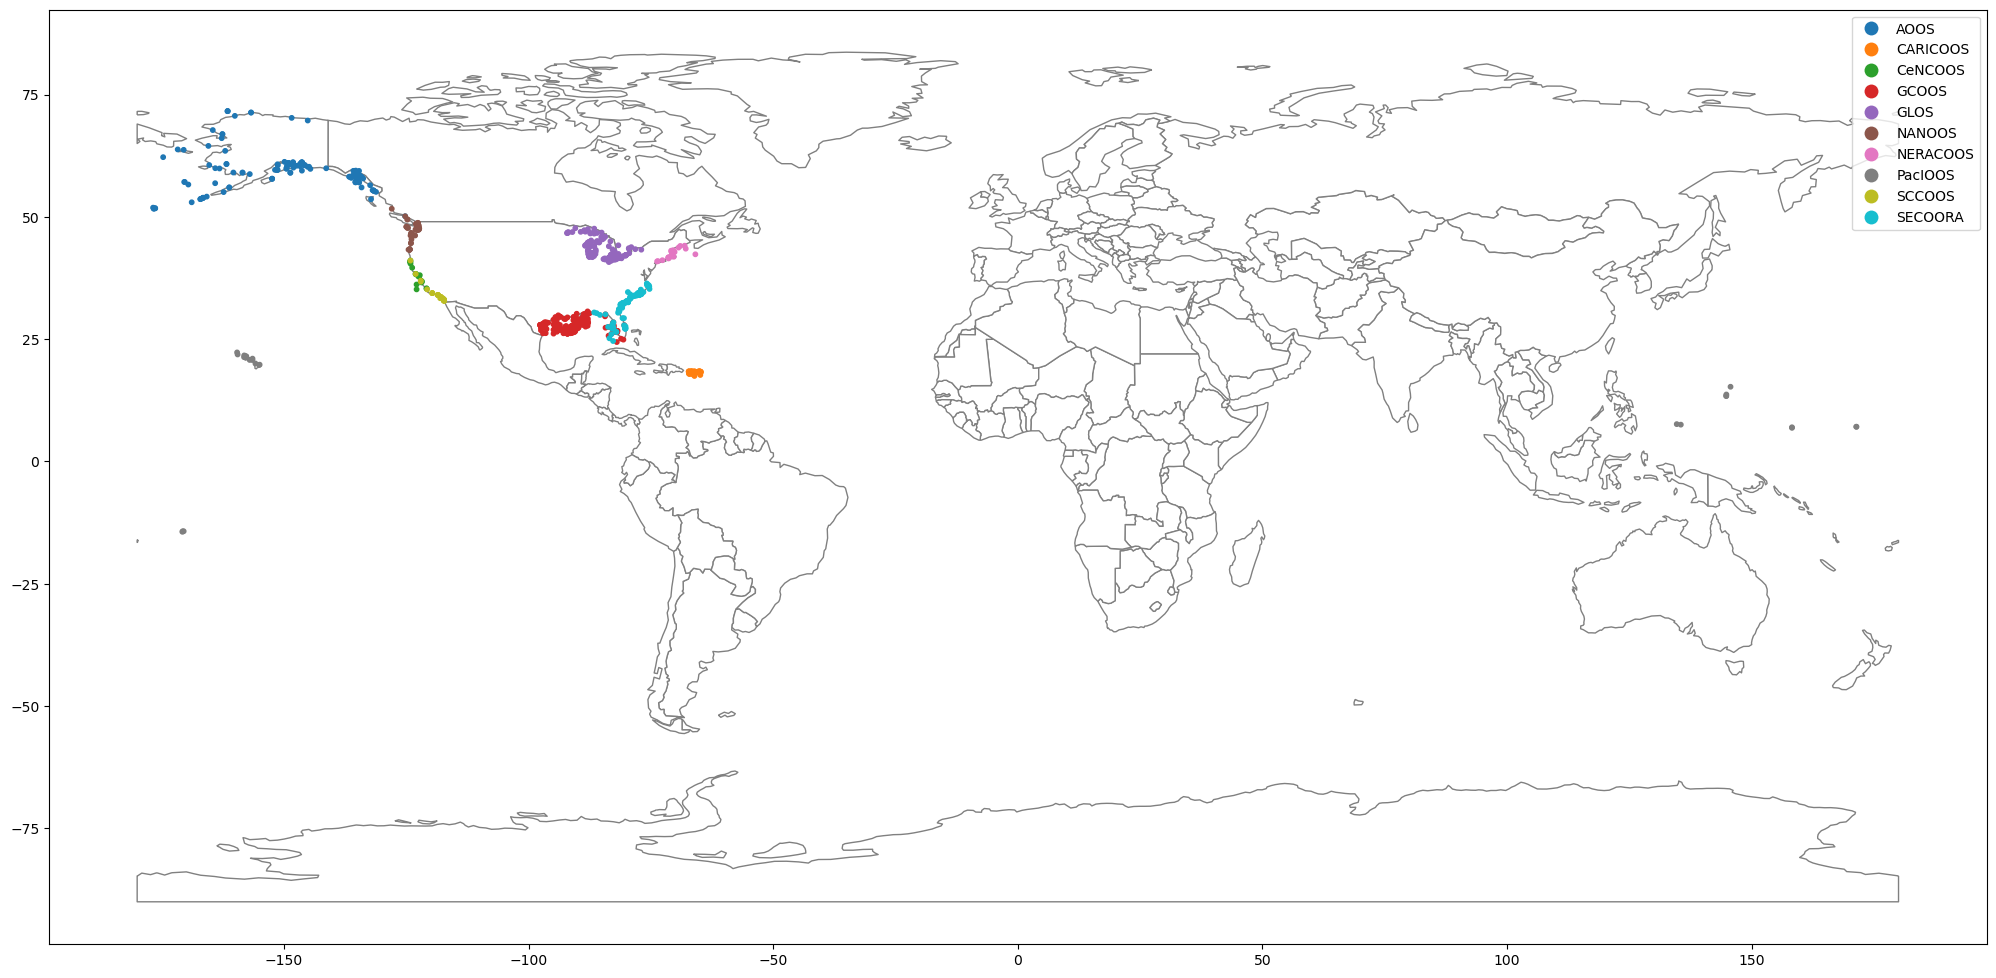

In [14]:
gdf = geopandas.GeoDataFrame(
    df_all, geometry=geopandas.points_from_xy(df_all['Longitude'], df_all['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot(ax=ax, 
         column='RA', 
         categorical=True, 
         markersize=10, 
         legend=True,
         k=11,
        )

plt.show()

Create a final DataFrame for processed file

In [15]:
df_final = pd.DataFrame(columns=
                        ['RA','Latitude','Longitude','Platform','Operational',
                         'RA_Funded','Water_temp','Salinity','Wtr_press',
                         'Dew_pt','Rel_hum','Air_temp','Winds','Air_press',
                         'Precip','Solar_radn','Visibility','Water_level','Waves',
                         'Currents','Turbidity','DO','pCO2_water','pCO2_air','TCO2',
                         'pH','OmgArag_st','Chl','Nitrate','CDOM','Alkalinity','Acoustics','file'])

df_final['RA'] = df_all['RA']
df_final['station_long_name'] = df_all['Station_Long_Name']
df_final['Latitude'] = df_all['Latitude']
df_final['Longitude'] = df_all['Longitude']
df_final['Platform'] = df_all['Platform_Type']
df_final['Operational'] = df_all['Currently_Operational']
df_final['station_deployment'] = df_all['Station_Deployment']
df_final['RA_Funded'] = df_all['RA_Funded']
df_final['Raw_Vars'] = df_all['Variable_Names']
df_final['file'] = df_all['file']

Map provided variable text to standard vars and platforms to consistent platform categories

In [16]:
import utils.mapping

df_final = utils.mapping.variables(df_final, df_all)
df_final = utils.mapping.platforms(df_final)

Reorganize the DataFrame

In [17]:
cols = ['RA', 'Latitude', 'Longitude', 'station_long_name', 'Platform', 'Operational', 'station_deployment', 
        'RA_Funded', 'Water_temp', 'Salinity', 'Wtr_press', 'Dew_pt', 'Rel_hum', 'Air_temp',
        'Winds', 'Air_press', 'Precip', 'Solar_radn', 'Visibility',
        'Water_level', 'Waves', 'Currents', 'Turbidity', 'DO', 'pCO2_water',
        'pCO2_air', 'TCO2', 'pH', 'OmgArag_st', 'Chl', 'Nitrate', 'CDOM',
        'Alkalinity', 'Acoustics', 'Raw_Vars','file']
df_final = df_final[cols]

Create a geopandas DataFrame.

In [18]:
gdf_final = geopandas.GeoDataFrame(
    df_final, geometry=geopandas.points_from_xy(df_final['Longitude'], df_final['Latitude']))

Write data files.

In [19]:
print('Saving inventory files...')
# csv
df_raw.to_csv(year+'/combined_raw_inventory.csv', index=False)
df_final.drop(labels='geometry', axis='columns', inplace=True)
df_final.to_csv(year+'/processed_inventory.csv', index=False)

# geojson
gdf.to_file(year+'/combined_raw_inventory.geojson', driver='GeoJSON')
gdf_final.to_file(year+'/processed_inventory.geojson', driver='GeoJSON')

# kml
gdf.to_file(year+'/combined_raw_inventory.kml', driver='LIBKML')
gdf_final.to_file(year+'/processed_inventory.kml', driver='LIBKML')

Saving inventory files...


In [20]:
gdf_final = gdf_final.set_crs(epsg=4326)

gdf_final.loc[gdf_final['geometry'].is_empty == False].explore("RA",categorical=True, tooltip=33, tiles="CartoDB dark_matter")

Find empty coordinates

In [21]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Latitude,Longitude,station_long_name,Platform,Operational,station_deployment,RA_Funded,Water_temp,Salinity,...,pH,OmgArag_st,Chl,Nitrate,CDOM,Alkalinity,Acoustics,Raw_Vars,file,geometry


Doing some digging

In [22]:
# df_all.loc[
#     (df_all['RA']=='SECOORA') & (df_all['Currently Operational? (Y, N, O, U)']=='Y'),
#     ['Station ID','Station Description','WMO ID or NWS/CMAN ID','Latitude','Longitude','RA Funding Involvement (Yf, Yp, N)','Currently Operational? (Y, N, O, U)','Additional notes']
# ]

# Save map image

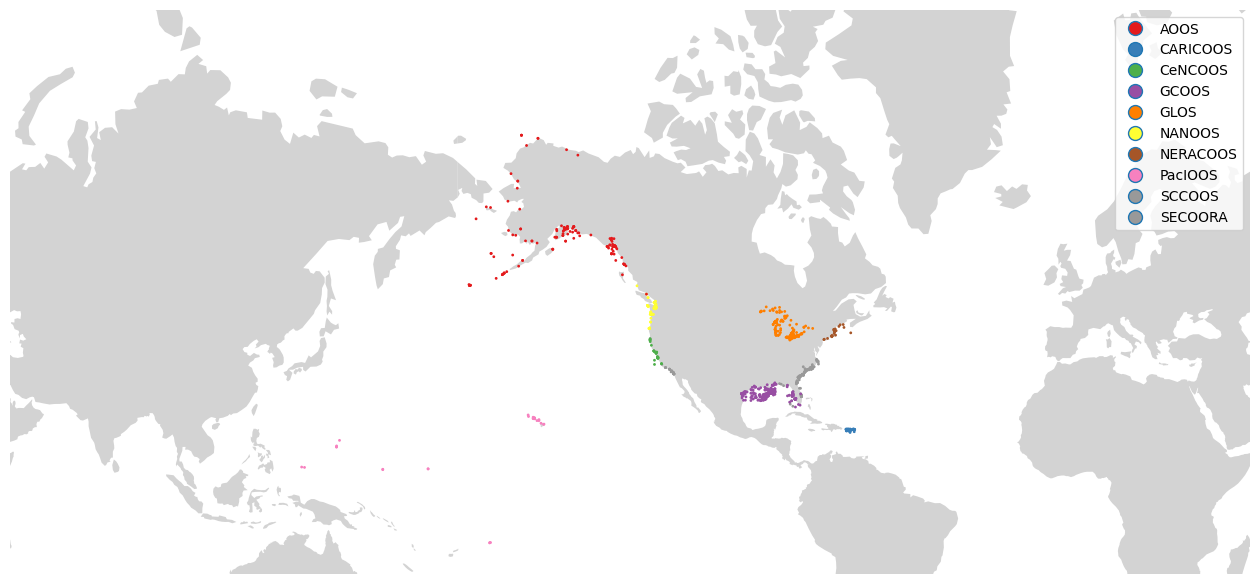

In [23]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mpl.colors.Normalize(vmin=1, vmax=1000)

#projection=gcrs.Mollweide(central_longitude=-130)
projection = gcrs.Mercator(central_longitude=-130)


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(16,8), facecolor=None, subplot_kw={'projection':projection})

geoplot.polyplot(
    world.dissolve(),
    #world,
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
    ax=ax,
)

# cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])

#cell = cell[~cell['n_occur'].isna()] # drop all NaN cells - makes plotting quicker.

geoplot.pointplot(gdf_final, 
                   hue='RA', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Set1',
                   legend=True,
                   scale='Latitude',
                   limits=(1,1),
                   legend_var='hue',
#                    legend_kwargs={'orientation': 'horizontal',
#                                   'cax':cax,
#                                   'label':"occurrence (count)",
#                                  },
                 #  norm=norm, 
                  )

#ax.set_global(); 

#ax.outline_patch.set_visible(True)

# or define your own as a list [xmin, xmax, ymin, ymax]
# extent = [gdf_final['Latitude'].min(), gdf_final['Latitude'].max(), gdf_final['Longitude'].max(), gdf_final['Longitude'].min()]

# ax.set_extent(extent)

plt.savefig(year+'/station_location_map.jpg')